In [1]:
from itertools import product

import diffrax as dfx
import equinox as eqx
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
from dynamical_systems.analysis.jacobian import jacobian
from dynamical_systems.continuous import Lorenz63
from dynamical_systems.metrics import (
    cosine_similarity as cosine_similarity,
    maximum_mean_discrepancy as maximum_mean_discrepancy,
    mean_squared_error as mean_squared_error,
    sinkhorn_divergence as sinkhorn_divergence,
)
from dynamics_discovery.dataset import TimeSeriesDataset
from dynamics_discovery.io import load_model
from dynamics_discovery.metrics.error import relative_error_norm
from dynamics_discovery.preprocessing import (
    add_noise,
    standardize,
)
from tqdm import tqdm


plt.style.use("matplotlib_utils.styles.dash_gridded")
jax.config.update("jax_enable_x64", True)

In [2]:
@eqx.filter_jit
def solve_batch(ode, t, u0_batch, rtol=1e-9, atol=1e-9, **kwargs):
    @eqx.filter_vmap
    def _solve(u0):
        sol = dfx.diffeqsolve(
            dfx.ODETerm(ode.rhs),
            dfx.Tsit5(),
            0.0,
            t[-1],
            None,
            u0,
            saveat=dfx.SaveAt(ts=t),
            stepsize_controller=dfx.PIDController(rtol=rtol, atol=atol),
            **kwargs,
        )
        return sol.ys

    return _solve(u0_batch)

100%|██████████| 24/24 [06:45<00:00, 16.89s/it]


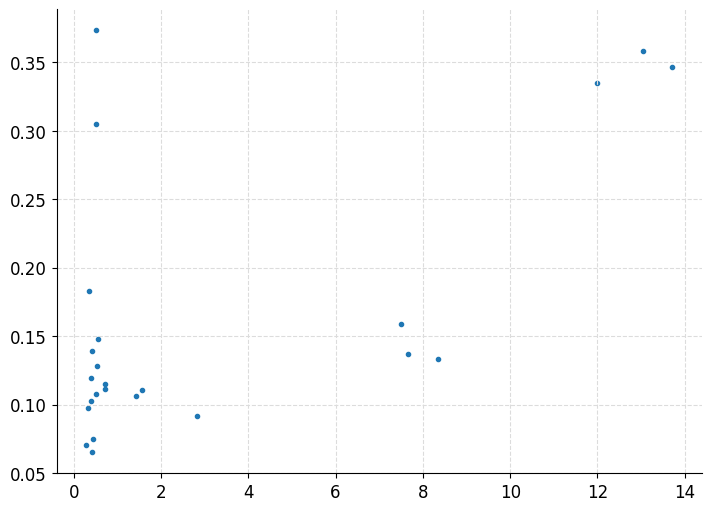

In [27]:
metrics = []
noise = 0.02
batch_lengths = np.asarray([2, 5, 10, 20, 50, 77, 100, 125])
t_long_term = jnp.asarray([0.1, 1.0, 10.0, 50.0])

dataset_train = TimeSeriesDataset.load("../../data/lorenz63_new.hdf5")
dataset_test = TimeSeriesDataset.load("../../data/lorenz63_new_test.hdf5")

lorenz = Lorenz63()

t_train = dataset_train.t[0]
u_orig = add_noise(dataset_train.u[0], noise)
u_train, u_test = standardize(u_orig, dataset_test.u[0])
u_std = jnp.std(u_orig, axis=0)

jac_unscaled = jacobian(lorenz, t_train, dataset_test.u[0])
jac_true = jnp.diag(1 / u_std) @ jac_unscaled @ jnp.diag(u_std)

u_test_batch_true = solve_batch(
    Lorenz63(), t_long_term, dataset_test.u[0], max_steps=None
)
u_test_batch_true = (u_test_batch_true - jnp.mean(u_orig, axis=0)) / jnp.std(
    u_orig, axis=0
)


# @eqx.filter_jit
def inner(model):
    jac_nn = jacobian(model, t_train, u_test)
    jac_err = jnp.mean(relative_error_norm(jac_nn, jac_true, ord=2, axis=(-2, -1)))

    u_test_batch_pred = solve_batch(model, t_long_term, u_test, max_steps=None)
    sinkdiv = eqx.filter_vmap(sinkhorn_divergence, in_axes=(1, 1))(
        u_test_batch_true, u_test_batch_pred
    )
    return jac_err, sinkdiv, jac_nn


fig, ax = plt.subplots(1, 1, figsize=(7, 5))

for noise in (0.05,):
    jac_errs = []
    sinkhorns = []
    jac_nns = []
    for b_len, seed in tqdm(
        product(batch_lengths, (0, 10, 20)),
        total=3 * len(batch_lengths),
    ):
        model = load_model(
            f"../../results/lorenz63_neuralode/len={b_len}_downsample=1_noise={noise}_key={seed}.eqx"
        )

        jac_err, sinkdiv, jac_nn = inner(model)
        jac_errs.append(jac_err)
        sinkhorns.append(sinkdiv)
        jac_nns.append(jac_nn)
    ax.scatter(
        np.asarray(jac_errs), np.asarray(sinkhorns)[:, -2], label=f"noise = {noise}"
    )

In [29]:
jac_nn_arr = jnp.asarray(jac_nns)
svd_nn = jnp.linalg.svd(jac_nn_arr)

In [31]:
svd_true = jnp.linalg.svd(jac_true)

In [45]:
svd_true[0].shape

(10000, 3, 3)

In [43]:
out = jnp.mean(
    jnp.sum(
        jnp.mean((svd_nn[0] * svd_nn[1] - svd_true[0] * svd_true[1]) ** 2, axis=-1),
        axis=-1,
    ),
    axis=-1,
)
out.shape

ValueError: Incompatible shapes for broadcasting: shapes=[(24, 10000, 3, 3), (24, 10000, 3)]

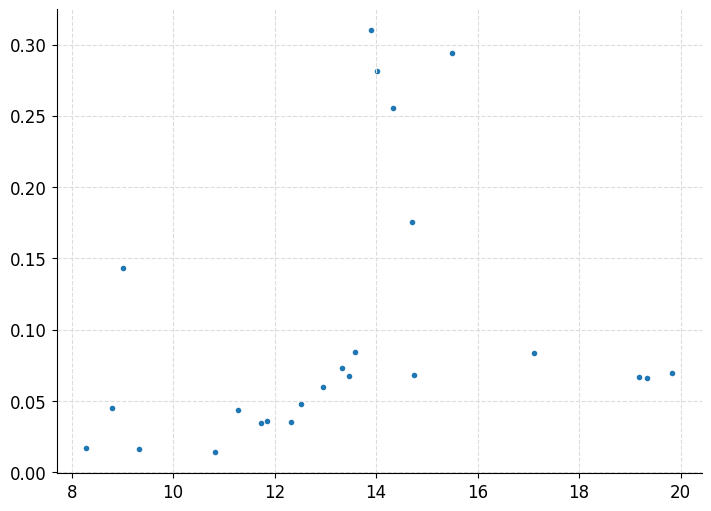

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
ax.scatter(out, np.asarray(sinkhorns)[:, -1], label=f"noise = {noise}")

In [18]:
jac_errs

[Array(5.47864045, dtype=float64),
 Array(4.60599642, dtype=float64),
 Array(5.24837288, dtype=float64),
 Array(0.95986256, dtype=float64),
 Array(0.899879, dtype=float64),
 Array(1.2262111, dtype=float64),
 Array(0.20410172, dtype=float64),
 Array(0.194285, dtype=float64),
 Array(0.26693935, dtype=float64),
 Array(0.24157088, dtype=float64),
 Array(0.2114538, dtype=float64),
 Array(0.19883114, dtype=float64),
 Array(0.3386373, dtype=float64),
 Array(0.33785102, dtype=float64),
 Array(0.22162726, dtype=float64),
 Array(0.36168967, dtype=float64),
 Array(0.39614647, dtype=float64),
 Array(0.26783945, dtype=float64),
 Array(0.43254373, dtype=float64),
 Array(0.48267561, dtype=float64),
 Array(0.31347021, dtype=float64),
 Array(0.5820361, dtype=float64),
 Array(0.60917071, dtype=float64),
 Array(0.45189975, dtype=float64)]